In [1]:
import pandas as pd
import numpy as np
import json

#-- show plots in notebook
%matplotlib inline

#-- Import analysis functions
import functions as func

#-- Read data into pandas from CSV
data = pd.read_csv(r'turnstile_weather_v2.csv')

# One other derived feature to explore (hour of day of week):
data['hour_day_week'] = data['day_week']*100 + data['hour']

# Analyzing the NYC Subway Dataset
## by Ian Edington

###Section 0. References
####References used for this project:
1. https://en.wikipedia.org/wiki/Mann–Whitney_U_test
2. https://statistics.laerd.com/spss-tutorials/mann-whitney-u-test-using-spss-statistics.php
3. http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html
4. http://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html
5. http://docs.scipy.org/doc/numpy/reference/generated/numpy.sum.html
6. http://pandas.pydata.org/pandas-docs/stable/visualization.html#histograms
7. http://pandas.pydata.org/pandas-docs/stable/groupby.html
8. http://pypi.python.org/pypi/ggplot/
9. http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
10. http://stackoverflow.com/questions/12190874/pandas-sampling-a-dataframe
11. http://stackoverflow.com/questions/19711943/pandas-dataframe-to-dictionary-value
12. http://stackoverflow.com/questions/7001606/json-serialize-a-dictionary-with-tuples-as-key
13. http://statsmodels.sourceforge.net/0.5.0/generated/statsmodels.regression.linear_model.OLS.html
14. http://statsmodels.sourceforge.net/0.5.0/generated/statsmodels.regression.linear_model.OLS.fit.html
15. http://statsmodels.sourceforge.net/0.5.0/generated/statsmodels.regression.linear_model.RegressionResults.html
16. http://wiki.scipy.org/Cookbook/Matplotlib/BarCharts
17. http://www.itl.nist.gov/div898/handbook/pri/section2/pri24.htm

###Section 1. Statistical Test
####1.1 Which statistical test did you use to analyze the NYC subway data?
The Mann-Whitney U test was used to determine if ridership on days where there was rainfall was significantly different than ridership on days where there was no rainfall. This same test was used to determine if ridership on days where there was fog was significantly different than ridership on days where there was no fog.
####Did you use a one-tail or a two-tail P value?
I used two-tailed P values in order to determine directionality.
####What is the null hypothesis?
Ridership does not change based on if it’s raining or not that day.

**H<sub>0</sub>: μ<sub>rain</sub> = μ<sub>no rain</sub><br/>
H<sub>0</sub>: μ<sub>fog</sub> = μ<sub>no fog</sub>**

####What is your p-critical value?
0.05

####1.2 Why is this statistical test applicable to the dataset? In particular, consider the assumptions that the test is making about the distribution of ridership in the two samples.

This test is applicable because the assumptions made by the Mann- Whitney U test are true about this data and because the question we were asking can be answered by this test.
Based on Wikipedia’s article these are the assumptions made by the
Mann-Whitney U test and evidence that this data set conforms to these assumptions.
1. All the observations from both groups are independent of each other:
We assume that the ridership of one hour is not based on the ridership of the previous hour or the previous day. This is a reasonable assumption since
2. The responses are at least ordinal: The dependent variable ENTRIESn_hourly is a continuous range of positive whole numbers.
3. The null hypothesis H0 is "The distributions of both populations are equal"
4. The alternative hypothesis H1 is "the probability of an observation from the population X exceeding an observation from the second population Y is different from the probability of an observation from Y exceeding an observation from X : P(X>Y)≠P(Y>X).”

From Laerd Statistics we have two additional assumptions:
5. You have one independent variable that consists of two categorical, independent groups:
This is true for both rain and fog variables: 1 and 0
6. You must determine whether the distribution of scores for both groups of your independent variable have the same shape or a different shape.

We can see based on the histograms for both rain and fog that the distributions have the same shape.

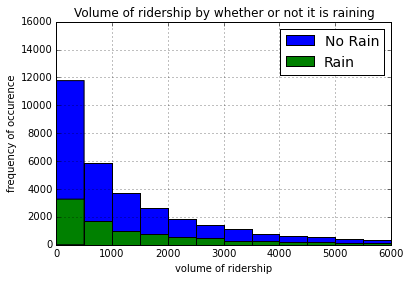

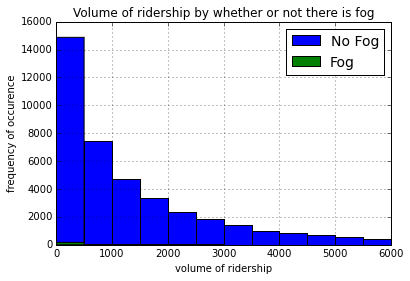

In [2]:
### Testing the hypothesis for Rain and Fog
#-- Select out the two sections for each one:
no_rain = data[data.rain == 0]['ENTRIESn_hourly']
rain = data[data.rain == 1]['ENTRIESn_hourly']
no_fog = data[data.fog == 0]['ENTRIESn_hourly']
fog = data[data.fog == 1]['ENTRIESn_hourly']

#-- Test selection: make a hist of the data
func.hist_MWW_suitability(no_rain, rain, rORf='rain').show()
func.hist_MWW_suitability(no_fog, fog, rORf='fog').show()

####1.3 What results did you get from this statistical test? P-values and the means for each of the two samples under test.

In [3]:
#-- compare Rain and Fog using Mann-Whitney statistic
MWU_rf = {'rain': list(func.mann_whitney_plus_means(no_rain, rain)),
        'fog': list(func.mann_whitney_plus_means(no_fog, fog))}

print(pd.DataFrame(MWU_rf, index= ['mean with_rain',
                                 'mean without_rain',
                                 'Mann-Whitney U-statistic',
                                 'Mann-Whitney p-value']))

                                     fog          rain
mean with_rain               1889.116150  1.845539e+03
mean without_rain            1631.980907  2.028196e+03
Mann-Whitney U-statistic  8167089.000000  1.536351e+08
Mann-Whitney p-value            0.006688  5.482139e-06


####1.4 What is the significance and interpretation of these results?
For the case of both Rain and Fog we reject the null hypothesis. This means that when it is raining the NYC subway is likely to have a hirer ridership than when it is not raining. Likewise for fog.

###Section 2. Linear Regression
####Feature Selection

#####All features

In [18]:
print(data.columns.tolist())

['UNIT', 'DATEn', 'TIMEn', 'ENTRIESn', 'EXITSn', 'ENTRIESn_hourly', 'EXITSn_hourly', 'datetime', 'hour', 'day_week', 'weekday', 'station', 'latitude', 'longitude', 'conds', 'fog', 'precipi', 'pressurei', 'rain', 'tempi', 'wspdi', 'meanprecipi', 'meanpressurei', 'meantempi', 'meanwspdi', 'weather_lat', 'weather_lon', 'hour_day_week']


#####Possible Colinearity
The variables related to Station might be colinear, ie. station, UNIT, latitude, longitude, weather_lat, weather_lon. If they are only one can be used in linear regression. This will test if they are perfectly colinear.

In [5]:
print(func.are_features_perfectly_colinearity(data, ['station', 'UNIT', 'latitude', 'longitude', 'weather_lat', 'weather_lon']))

perfectly colinear


#####Features that are acceptable for linear regression
UNIT, latitude, longitude, weather_lat, and weather_lon can be eliminated as features due to theis colinearity with station. ENTRIESn, EXITSn, EXITSn_hourly can be eliminated since they are derived from ENTRIESn_hourly. DATEn, TIMEn, and datetime were eliminated, however, hour, day_week, weekday, and hour_day_week (which were derived from datetime) will be included.

In [2]:
# Feature to pick from:
features = ['hour', 'day_week', 'weekday', 'hour_day_week', 'station', 'conds', 'fog', 'precipi', 'pressurei', 'rain', 'tempi', 'wspdi', 'meanprecipi', 'meanpressurei', 'meantempi', 'meanwspdi']

# Features to use as dummy variables
dummy_vars = ['hour', 'day_week', 'weekday', 'hour_day_week', 'station', 'conds']

In [ ]:
results = func.feature_testing(data, features, dummy_vars)

starting test at 1437959051.127545
['hour']
ending test at 1437959051.190945/n
starting test at 1437959051.191597
['day_week']
ending test at 1437959051.253672/n
starting test at 1437959051.254311
['weekday']
ending test at 1437959051.287552/n
starting test at 1437959051.2876
['hour_day_week']
ending test at 1437959051.977471/n
starting test at 1437959051.978128
['station']
ending test at 1437959058.425187/n
starting test at 1437959058.425868
['conds']
ending test at 1437959058.614423/n
starting test at 1437959058.615105
['fog']
ending test at 1437959058.636345/n
starting test at 1437959058.636393
['precipi']
ending test at 1437959058.654749/n
starting test at 1437959058.654798
['pressurei']
ending test at 1437959058.67104/n
starting test at 1437959058.671693
['rain']
ending test at 1437959058.687184/n
starting test at 1437959058.68723
['tempi']
ending test at 1437959058.702705/n
starting test at 1437959058.702751
['wspdi']
ending test at 1437959058.718937/n
starting test at 1437959058

In [ ]:
dicresults = pd.DataFrame(results, index=['rsquared', 'features', 'int_params', 'params_names'])
dicresults = dicresults.transpose().sort(columns='rsquared', axis=0, ascending=False)
print(dicresults[['rsquared', 'features']].head(5))


In [7]:
from itertools import combinations
all_features = ['hour', 'conds', 'meantempi', 'meanwspdi']

results = {}
i=0
tr_data, ts_data = func.train_ts_data(data)

## Create numpy arrays
values_array = tr_data['ENTRIESn_hourly'].values
test_values_array = ts_data['ENTRIESn_hourly'].values

for L in range(1, len(all_features)+1):
    for subset in combinations(all_features, L):
        features = list(subset)

        feature_array, test_feature_array, params_names = func.make_feature_arrays(tr_data, ts_data, features, dummy_vars)

        #-- generate predictions
        intercept, params = func.OLS_linear_regression(feature_array, values_array)

        #-- calculate r** using ts_data
        predictions = (test_feature_array*params).sum(axis=1) + intercept
        r_squared = func.compute_r_squared(test_values_array, predictions)
        #-- append results to list
        results[i] = [r_squared, [features], [intercept, params.tolist()], params_names]
        i+=1


####2.1 What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model:
OLS using Statsmodels

####2.2 What features (input variables) did you use in your model?
I used UNIT, Hour, day_of_week as the input variables of my model.
Did you use any dummy variables as part of your features?
For UNIT, Hour, day_of_week I used dummy variables based on the mean of the Entries.

####2.3 Why did you select these features in your model?
I used these features because they had the greatest +ve impact on the r squared value. To calculate the r squared value I used parameters generated by the OLS model to make predictions of a set of test data, then compared the predictions to the recorded data.
Using only UNIT, Hour and day_of_week I got an r-squared value of 0.49370326835188771 compared to 0.49469115125765351 for 8 features (UNIT_means, Hour_means, day_of_week_means, maxtempi, precipi, fog, rain and maxdewpti).
I felt that the added features didn’t add enough benefit to justify including them.

####2.4 What are the parameters (also known as "coefficients" or "weights") of the non-dummy features in your linear regression model?
I made a transformation to all my features before implementing OLS by calculating the mean entries for each of these features.
Intercept: -1817.4548075398768 day_of_week_means: 0.9687637785441505
UNIT_means: 0.9427523353608755 Hour_means: 0.7492225446047587

####2.5 What is your model’s R2 (coefficients of determination) value?
R2 value: 0.49370326835188771

####2.6 What does this R2 value mean for the goodness of fit for your regression model?
R2 on its own isn’t a good indicator of a models fit. More graphical methods need to be used to determine if it is a good fit or not. Specifically, looking at the residuals.
Do you think this linear model to predict ridership is appropriate for this dataset, given this R2 value?
R2 doesn’t tell us if we have the right model, only how much our data varies from the model. If a large portion of the data can’t be explained by a model the R2 will always be low wether or not we have a good fit. However, based on graphs of the data I don’t think a linear model is the best way to predict ridership for most features in this dataset because most of the data appears to be non-linear.